**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 8 and 9: Assignment (100 points + 10 bonus points)*  
Adapted from Andrew Ng's deep learning course.

In [1]:
# Group number: 14
# Veerle Schepers s1023102
# Angeliki-Ilektra Karaiskou, s1029746
# Lei Xiaoxuan, s1025681
# Parsia Basimfar : s1022274

# Deep Learning & Art: Neural Style Transfer

In this assignment, you will learn about Neural Style Transfer. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [2]:
import chainer
import os
from os import listdir
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import ssl
import IPython


%matplotlib inline

from chainer import backend
from chainer import backends
from chainer.backends import cuda
import chainer.functions as F
from chainer import Variable, optimizers
from chainer import Link, Chain, ChainList

import chainer.links as L
from chainer.training import extensions
#import cupy as cp

NOISE_RATIO=0.6

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Heyendaal castle in Nijmegen (content image C), mixed with a painting by Vincent van Gogh, a leader of the post-impressionist movement (style image S).

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [3]:
#!curl -O http://www.robots.ox.ac.uk/%7Evgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel
#model_1 = chainer.links.VGG19Layers()


## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Heyendaal castle in Nijmegen. Run the code below to see a picture of the Heyendaal castle.

'wget' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\Serafeim\Anaconda3\envs\angenv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Serafeim\Anaconda3\envs\angenv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


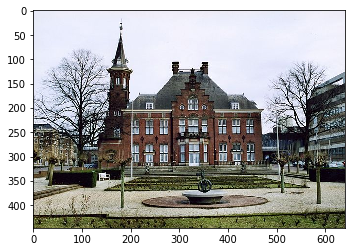

In [4]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Heyendaal.jpg/640px-Heyendaal.jpg
content_image = scipy.misc.imread("640px-Heyendaal.jpg")
imshow(content_image)
scipy.misc.imsave('content_img_gogh.jpg',content_image)

** 3.1.1 - How do you ensure the generated image G matches the content of the image C?**

As we saw in lecture, the earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. 

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $a^{(G)}$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

<img src="https://i.postimg.cc/YqbBM5jM/NST-LOSS.png">



**Exercise (10 points)**

Compute the "content cost" using Chainer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from a_G.
2. Unroll a_C and a_G.
3. Compute the content cost.

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # retrieve dimensions of hidden layer activations
    n_C,n_H,n_W = a_G.shape;
    # unroll a_C and a_G

    a_C_2d = F.reshape(a_C,[n_C,n_H*n_W]);
    a_G_2d = F.reshape(a_G,[n_C,n_H*n_W]);

    J_content = (1/(4*n_H*n_W*n_C))*F.sum(F.square(a_C_2d - a_G_2d))

    ### END CODE HERE ###
    
    return J_content

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

'wget' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\Serafeim\Anaconda3\envs\angenv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Serafeim\Anaconda3\envs\angenv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


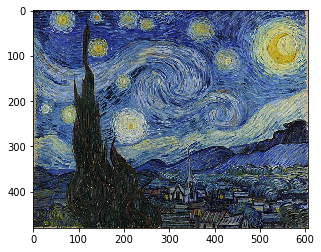

In [6]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/606px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
style_image = scipy.misc.imread("606px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")
imshow(style_image)
scipy.misc.imsave('style_img_Van_Gogh.jpg',style_image)

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="https://i.postimg.cc/Fzx5fqZb/NST-GM.png">

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 



**Exercise (10 points)**:
Using Chainer, implement a function that computes the Gram matrix of a matrix A. The formula is: The gram matrix of A is $G_A = AA^T$.

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ###
    A_trans = F.transpose(A)
    GA = F.matmul(A,A_trans)
    
    ### END CODE HERE ###
    
    return GA

### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


**Exercise (10 points)**:

Compute the style cost for a single layer. 

The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost.

In [8]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    
    # 1. retreive dimensions from a_G
    n_C,n_H,n_W = a_G.shape;
    
    # 2. unroll the tensor
    a_S_2d = F.reshape(a_S,[n_C,n_H*n_W]);
    a_G_2d = F.reshape(a_G,[n_C,n_H*n_W]);    
    # 3 & 4. compute the style matrix and style cost 
    a_S_2d =gram_matrix(a_S_2d)
    #print(a_S_2d.shape)
    a_G_2d = gram_matrix(a_G_2d)
    #print(a_G_2d.shape)
    J_style_layer = F.sum(F.square(a_S_2d - a_G_2d)) / (4 * (n_C* n_W * n_H)**2)
    ### END CODE HERE ###
    
    return J_style_layer

### 3.2.3 Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default: 

In [9]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]


style=[]
for i in range(0,5):
    style.append(STYLE_LAYERS[i][0])
print(style)

['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']


You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


**Exercise (10 points)**

Implement the `compute_style_cost(...)` function. It should simply call the `compute_layer_style_cost(...)` several times, and weight their results using the values in `STYLE_LAYERS`.

In [10]:

def compute_style_cost(STYLE_LAYERS,input_image,style_image):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    L = len(STYLE_LAYERS)
    G = input_image
    S = style_image
    J_style_final=0
    for i in range(0,L):
        layersname=STYLE_LAYERS[i][0]
        gen_input=G[layersname][0]
        style_input = S[layersname][0]
        weights=STYLE_LAYERS[i][1]
        J_style_final += weights*compute_layer_style_cost(gen_input,style_input)

    return J_style_final

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise (10 points)**

Implement the total cost function which includes both the content cost and the style cost.

In [11]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ###
    J = alpha*J_content + beta*J_style;
    ### END CODE HERE ###
    
    return J

In [12]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.random(content_image.shape)
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = (noise_image * noise_ratio + content_image * (1 - noise_ratio)).astype(np.float32)
    return input_image

## 4 - Solving the optimization problem (50 points)

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG16 model
5. Build a Chainer Model:
    6. Run the content image through the VGG16 model and compute the content cost
    7. Run the style image through the VGG16 model and compute the style cost
    8. Compute the total cost
    9. Define the optimizer and the learning rate
10. Initialize the Chainer model and run it for a large number of iterations, updating the generated image at every step.

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [26]:
class Loss(object):
    def __init__(self):
        pass

    def __call__(self, content_orig, style_orig, generated_orig, STYLE_LAYERS,layer_name='conv3_1'):

        generated_orig_style = generated_orig[layer_name][0]
        J_content = compute_content_cost(content_orig, generated_orig_style)
        J_style = compute_style_cost( STYLE_LAYERS, style_orig, generated_orig)
        J = total_cost(J_content, J_style)
        print(J)
        return J

# TIP: How to make generated image model parameter
class Model (Chain):
    def __init__(self, generated_image):
        super().__init__()
        with self.init_scope():
            self.generated_image = chainer.Parameter(generated_image)
            
    def __call__(self):
        return self.generated_image

    
class Generate_Image(Chain):
    def __init__(self, generated_image):
        super().__init__()
        with self.init_scope():
            
            self.vgg=VGG()
            self.model=Model(generated_image)
            self.loss=Loss()
            self.optimizer = optimizers.Adam(alpha=2.0)
            self.optimizer.setup(self.model)
            
    def __call__(self,x,style_layer):
        
        y = self.model.forward(x,style_layer)
        
        return y
    
    def gen_img(self,content_image,style_image,style_layer,layer_name,max_iter):
        
        content_orig = self.vgg.forward(content_image,style_layer)
        style_orig = self.vgg.forward(style_image,style_layer)
        self.vgg.disable_update()
        loss_history=[]
        means = np.array([116.779,116.779,116.779], dtype=np.float32).reshape((3,1,1)) #means from vgg model
        for i in range(max_iter):       
            x = self.model()
            generated_orig=self.vgg(x,style_layer)

            cost=self.loss( content_orig[layer_name][0], style_orig, generated_orig, STYLE_LAYERS)

            self.model.cleargrads()
            cost.backward()
            self.optimizer.update()
            tmp_shape = x.data.shape
            
            xp = self.model.xp
            if i%1==0:
                print(i)
                print('cost')
                print(cost)
                
            loss_history.append(float(cost.data))
        
            IPython.display.clear_output()
            print('iteration: {:3d} / {:03d}, loss: {:.4f}'.format(i+1, max_iter, loss_history[-1]))
            plt.plot(np.array(loss_history).reshape(i + 1, -1).mean(1))
            plt.xlabel('iteration')
            plt.ylabel('training loss')
            plt.tight_layout()
            plt.show()
            #xp = model.xp
            x_out = x.data[0] 
            x_out = x_out + np.moveaxis(means, 0, 0)
            #x_out=np.moveaxis(x_out.astype(np.int64), 0, -1)
            plt.imshow(np.moveaxis(x_out.astype(np.int64), 0, -1))
            plt.show()
            if i % 100 == 0:
                result = Image.fromarray((np.moveaxis(x_out.astype(np.int64), 0, -1) * 255).astype(np.uint8))
                result.save('generated_bonus.png')
        return 
    
class VGG(Chain):
    def __init__(self):
        super(VGG, self).__init__()
        with self.init_scope():
            self.model=chainer.links.VGG19Layers()

    def forward(self, x,style):
        y = self.model.forward(x,layers=style)
        return y

In [14]:

def subtract_mean(x0):
    x = x0.copy()
    x[0,0,:,:] -= 116.779
    x[0,1,:,:] -= 116.779
    x[0,2,:,:] -= 116.779
    #means = np.array([116.779,116.779,116.779], dtype=np.float32).reshape((3,1,1))
    return x

def image_resize(img_file, width=224):
    img = img_file
    orig_w, orig_h = img.size[0], img.size[1]
    if orig_w>orig_h:
        new_w = width
        new_h = width*orig_h//orig_w
        img = np.asarray(img.resize((new_w,new_h)))[:,:,:3].transpose(2, 0, 1)[::-1].astype(np.float32)
        img = img.reshape((1,3,new_h,new_w))
        hoge= np.zeros((1,3,width,width), dtype=np.float32)
        hoge[0,:,width-new_h:,:] = img[0,:,:,:]
        img = subtract_mean(hoge)
    else:
        new_w = width*orig_w//orig_h
        new_h = width
        img = np.asarray(img.resize((new_w,new_h)))[:,:,:3].transpose(2, 0, 1)[::-1].astype(np.float32)
        img = img.reshape((1,3,new_h,new_w))
        hoge= np.zeros((1,3,width,width), dtype=np.float32)
        hoge[0,:,:,width-new_w:] = img[0,:,:,:]
        img = subtract_mean(hoge)
    return np.asarray(img), new_w, new_h

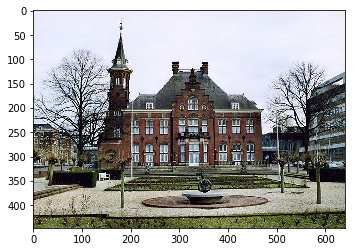

In [15]:
#from chainer.links import VGG16Layers
path=''
cnt_image = 'content_img_gogh.jpg'
st_image = 'style_img_Van_Gogh.jpg'

# 1. Load the content image
im = Image.open(path+cnt_image)
im.save(path +'content_img_gogh.png')
im_content=Image.open(path+'content_img_gogh.png')
imshow(im_content)
content_image,nw,nh=image_resize(im_content)

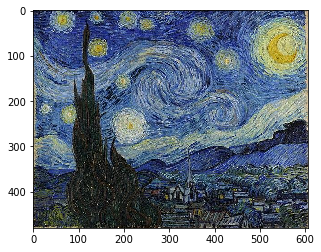

In [16]:
# 2. Load the style image

im = Image.open(path+st_image)
im.save(path +'style_img_gogh.png')
im_style=Image.open(path+'style_img_gogh.png')
imshow(im_style)
style_image,_,_ = image_resize(im_style)
 
# 3. Randomly initialize the image to be generated 
generated_image=generate_noise_image(content_image)

In [17]:
# 5. Build a Chainer Model:

layer_name='conv3_1'
loss_history = []
model_directory = "Models"
lr=2.0 #learning rate
model=Generate_Image(generated_image)
model.vgg.to_cpu()

max_iter=1000



iteration: 1000 / 1000, loss: 839549568.0000


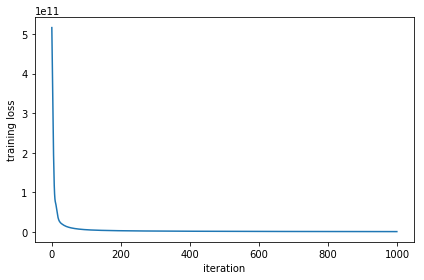

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


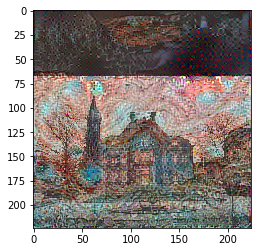

In [18]:

model.gen_img(content_image,style_image,style,layer_name,max_iter)
   

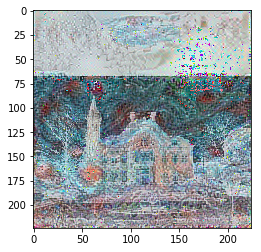

In [20]:
im = Image.open(path+'generated.png')
imshow(im)

## 5 - Test with your own image (10 bonus points)

Finally, you can also rerun the algorithm on your own images! 

You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

In [21]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.5),
    ('conv3_1', 0.8),
    ('conv4_1', 0.7),
    ('conv5_1', 0.1)]


style=[]
for i in range(0,5):
    style.append(STYLE_LAYERS[i][0])
print(style)

['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']


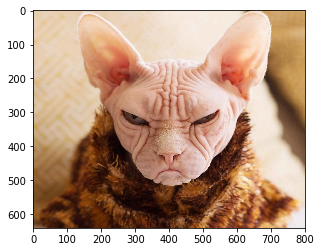

In [23]:
#from chainer.links import VGG16Layers
# 1. Load the content image
im = Image.open('cat2.jpg')
im.save('cat.png')
im_content=Image.open('cat.png')
content_image,nw,nh=image_resize(im_content)
imshow(im_content)

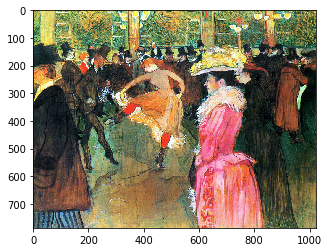

In [24]:
# 2. Load the style image
im = Image.open('lautrec-bal-moulin-rouge.jpg')
im.save('style_img.png')
im_style=Image.open('style_img.png')
style_image,_,_ = image_resize(im_style)
imshow(im_style)

In [25]:
# 3. Randomly initialize the image to be generated 
generated_image=generate_noise_image(content_image)

In [ ]:
# 5. Build a Chainer Model:

layer_name='conv3_1'
loss_history = []
model_directory = "Models"
lr=2.0 #learning rate
model=Generate_Image(generated_image)
model.vgg.to_cpu()

max_iter=1000

model.gen_img(content_image,style_image,style,layer_name,max_iter)

variable(3.1978905e+12)


## 7 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color='blue'>
What you should remember:
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images.

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015).

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)